# Housing - exploratory data analysis (EDA)

NYC housing dataset b/w in 2012-13, seperated by boroughs


##### Notes
- **raw_data** is readed file w/ proper types and formats
- **data_prepared**, dataframe after missing values (sale_price) and **obvious** rows/columns eliminated
- **data_cleaned**,  dataframe after **outliers** eliminated
- **data_enriched**, starts w/ data, + null row deletions, enrichments (_map, _log ..)  etc...

### possible deletion columns/rows

   - columns
       - borough, building_class_category .. (extracted into diff. columns)
       - block, lot (nonsense)
       - easement (%100 empty), 
       - apartment_number (%74 empty)
   - rows
       - **30% of sale_price is 0 (28K+)**
       - building_class_name is null, is **(1500)**
       - tax_class_at_present is empty, is **(270)**     
   - outliers  
       - (data_cleaned.gross_square_feet > 0) & (data_cleaned.gross_square_feet <= 20K)
       - (data_cleaned.sale_price < 2M)  


### categorical features

  - building_class_at_present has potential for dummie
  - building_class_at_present vs building_class_at_sale change has any meaning?
  - tax_class_at_present (7) or tax_class_at_sale (3) has potential for dummyie
  - 10019 zipcode is %7 of houses, and 70K houses are located in of 100 zipcodes
  - 4000+ diff. apartment_number in 85K rows.
  - top 50 neighborhood covers 50K+ houses
  
### numerical features

  - **50% of estates has 0 land_square_feet and gross_square_feet.**
  - **how can residential_units and commercial_units be used in a meaningful way?**
      - [ ] in every case, 17K has 0 unit. 
      - [ ] we should **tag** as residential and commercial (new feature of category)
      - [x] we should use total_units as numerical features


- [ ] can we predict year_built, then set 0 values,


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import glob

sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 250)


In [2]:
# tuning params

neighborhood_min_len = 2

sale_price_min = 1000 # minimum intuitive sales price
sale_price_lq = 0.01  # left quantile
sale_price_rq = 0.99  # right quantile

building_class_mapping = ['FAMILY', 'APARTMENT', 'FACILITIES'] # maps building_class_category

In [3]:
# read all datasets w/ dates
filenames = glob.glob(os.path.join('dataset/housing/', 'r*.csv'))

#
li = []

for filename in filenames:
    df = pd.read_csv(filename, \
                dtype={'YEAR BUILT': object, 'BLOCK': object, 'LOT': object, 'ZIP CODE': object, 
                       'COMMERCIAL UNITS': object,
                       'BOROUGH': object, 'NEIGHBORHOOD': object, 'BUILDING CLASS CATEGORY': object,
                       'TAX CLASS AT PRESENT': object,  'EASE-MENT': object,
                       'BUILDING CLASS AT PRESENT': object, 'ADDRESS': object, 
                       'APART\nMENT\nNUMBER': object,
                       'RESIDENTIAL UNITS': object, 'COMMERCIAL UNITS': object, 'TOTAL UNITS': object,
                       'LAND SQUARE FEET': object, 'GROSS SQUARE FEET': object,
                       'TAX CLASS AT TIME OF SALE': object, 'BUILDING CLASS AT TIME OF SALE': object,
                       'SALE\nPRICE': str}, \
                parse_dates=['SALE DATE'], \
                infer_datetime_format=True)
    li.append(df)


raw_data = pd.concat(li, axis=0, ignore_index=True)

# change column names
raw_data.columns = ['borough', 'neighborhood', 'building_class_category',
                    'tax_class_at_present', 'block', 'lot', 'easement',
                    'building_class_at_present', 'address', 'apartment_number',
                    'zipcode', 'residential_units', 'commercial_units', 'total_units',
                    'land_square_feet', 'gross_square_feet', 'year_built',
                    'tax_class_at_sale', 'building_class_at_sale',
                    'sale_price', 'sale_date']

raw_data.head(2)

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date
0,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1103,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$403,572",2013-07-09
1,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1105,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$218,010",2013-07-12


# Explore

- map and extract some of them, 
- delete white-spaces, 
- delete comma and $
- convert some object columns to number !
- check outliers
- reduced categorigal features into less
- delete rows and columns

### quick checks

In [125]:
raw_data.isnull().sum()

# no null, but empty values filled w/ blanks! so it requires more operations !

borough                      0
neighborhood                 0
building_class_category      0
tax_class_at_present         0
block                        0
lot                          0
easement                     0
building_class_at_present    0
address                      0
apartment_number             0
zipcode                      0
residential_units            0
commercial_units             0
total_units                  0
land_square_feet             0
gross_square_feet            0
year_built                   0
tax_class_at_sale            0
building_class_at_sale       0
sale_price                   0
sale_date                    0
dtype: int64

### mappings for categorical features

In [5]:
data = raw_data.copy()

In [6]:
data['borough_name'] = data['borough'].map({'1':'Manhattan', '3':'Brooklyn', 
                                                    '2':'Bronx', '4':'Queens', 
                                                    '5':'Staten Island'})   

data.borough_name.head(1)

0    Brooklyn
Name: borough_name, dtype: object

In [7]:
data.drop('borough', axis=1, inplace=True)

data.columns

Index(['neighborhood', 'building_class_category', 'tax_class_at_present',
       'block', 'lot', 'easement', 'building_class_at_present', 'address',
       'apartment_number', 'zipcode', 'residential_units', 'commercial_units',
       'total_units', 'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_sale', 'building_class_at_sale', 'sale_price',
       'sale_date', 'borough_name'],
      dtype='object')

### cleansing

- look via a text editor to see obvious issues
- start w/ dependent & numerical features

##### sale_price

In [8]:
x = data.copy()

In [9]:
# delete $ and , chars
# sale_price is object, but it has to be numeric !
x.groupby(x.sale_price).size().head(3)

sale_price
$0       26959
$0.00     1679
$1         147
dtype: int64

In [10]:
x['sale_price'] = x['sale_price'].str.replace(r',|\$', '').astype(float)

In [11]:
x.sale_price.describe()

# mean 885K, median 226K  -> skewed
# 50% quantile == 0.. delete'em all   ~28K
# 75% quantile and max value is enormuous . outliers

count    8.597500e+04
mean     8.850979e+05
std      9.424213e+06
min      0.000000e+00
25%      0.000000e+00
50%      2.600000e+05
75%      6.200000e+05
max      1.307965e+09
Name: sale_price, dtype: float64

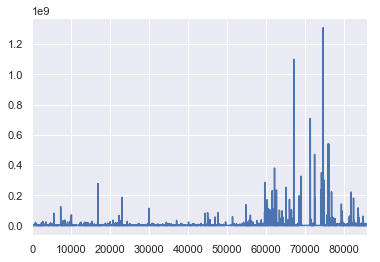

In [12]:
# x axis contains index number :)
# seems outliers

x.sale_price.plot()

In [13]:
x = x[x.sale_price > sale_price_min]

len(data), len(x)

(85975, 55900)

In [14]:
x.sale_price.describe()

# mean 1.3M, median 491K, still skewed
# min 1100, 25% 277K -> outliers from left
# 75% 850K, max 1.3b -> outliers from right

count    5.590000e+04
mean     1.361290e+06
std      1.165987e+07
min      1.100000e+03
25%      2.773358e+05
50%      4.910000e+05
75%      8.500000e+05
max      1.307965e+09
Name: sale_price, dtype: float64

In [15]:
# we can take b/w those values

q1 = x.sale_price.quantile(sale_price_lq)

q2 = x.sale_price.quantile(sale_price_rq)

q1, q2

(15000.0, 12150000.0)

(54767, <matplotlib.axes._subplots.AxesSubplot at 0x1a202239b0>)

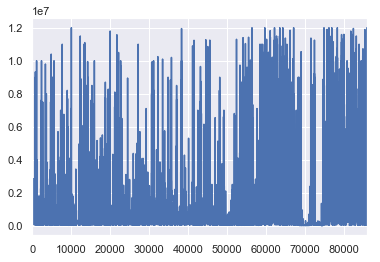

In [16]:
x = x[(x.sale_price > q1) & (x.sale_price < q2)]

len(x), x.sale_price.plot()

# seems much better
# still tuning opportunity, can be controlled by tuning params !

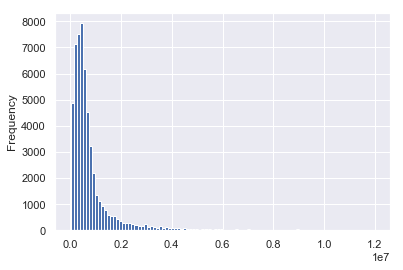

In [17]:
x.sale_price.plot.hist(bins=100)

In [18]:
data = x

##### neighborhood

In [20]:
x = data.copy()

In [21]:
# below means there are whitespaces or check inside a text editor

x[x.neighborhood == 'ANNADALE'].head()

,neighborhood,building_class_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date,borough_name


In [22]:
# if whitespaces at the begining, groupby is good. but not enough
# good for double checks 
# delete empty values 25/85K

data.groupby('neighborhood').size().head(5)

neighborhood
                              23
AIRPORT LA GUARDIA             3
ALPHABET CITY                111
ANNADALE                      99
ARDEN HEIGHTS                171
dtype: int64

In [23]:

x['neighborhood'] = x.loc[:, 'neighborhood'].str.split(r'(\s+)$', expand=True)[0]

In [24]:
x.groupby('neighborhood').size().head(3)

neighborhood
                       23
AIRPORT LA GUARDIA      3
ALPHABET CITY         111
dtype: int64

In [25]:
x[x.neighborhood == 'ANNADALE'].head(3)

# means whitespaces cleaned

,neighborhood,building_class_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date,borough_name
23373,ANNADALE,01 ONE FAMILY HOMES,1,5395,32,,A1,541 SYCAMORE STREET,,10312,1,0,1,"13,320","4,696",1985,1,A1,1200000.0,2012-08-15,Staten Island
23374,ANNADALE,01 ONE FAMILY HOMES,1,5401,10,,A2,16 JANSEN STREET,,10312,1,0,1,"10,800","2,015",1980,1,A2,705000.0,2013-02-08,Staten Island
23375,ANNADALE,01 ONE FAMILY HOMES,1,5401,38,,A1,27 WEAVER STREET,,10312,1,0,1,"10,833","2,128",1980,1,A1,127500.0,2012-09-26,Staten Island


In [26]:
# filter

x = x[x.neighborhood.str.len() > neighborhood_min_len]

In [27]:
# can we reduce into less groups ? (for dummy features)
# nope, or requires domain know-how

x.groupby('neighborhood').size().head()


neighborhood
AIRPORT LA GUARDIA      3
ALPHABET CITY         111
ANNADALE               99
ARDEN HEIGHTS         171
ARROCHAR               13
dtype: int64

In [28]:
x.neighborhood.describe()

count            54744
unique             252
top       MIDTOWN WEST
freq              2866
Name: neighborhood, dtype: object

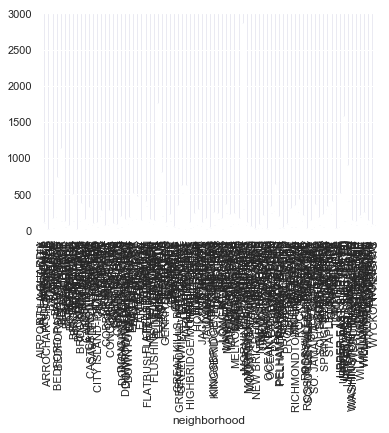

In [29]:
x.groupby('neighborhood').size().plot(kind='bar')

In [31]:
data = x

### building_class_category

- split into 2 columns (exract text)
- eliminate white spaces
- reduce into less categories (dummy variables)

In [33]:
x = data.copy()

In [34]:
# empty 1042 , delete'em all

x.groupby('building_class_category').size().head(10)

building_class_category
                                                1042
01  ONE FAMILY HOMES                            9337
02  TWO FAMILY HOMES                            7868
03  THREE FAMILY HOMES                          2121
04  TAX CLASS 1 CONDOS                           849
05  TAX CLASS 1 VACANT LAND                      415
06  TAX CLASS 1 - OTHER                           43
07  RENTALS - WALKUP APARTMENTS                 2118
08  RENTALS - ELEVATOR APARTMENTS                267
09  COOPS - WALKUP APARTMENTS                   2352
dtype: int64

In [35]:
x.building_class_category.describe()

count                                            54744
unique                                              38
top       10  COOPS - ELEVATOR APARTMENTS             
freq                                             12437
Name: building_class_category, dtype: object

In [36]:
kkk = pd.DataFrame(data['building_class_category'])


# (^\s)|(\s+)$
# r'(\s+)$' and r'(^\S+)(\s+)

kkk['building_class_category_'] = kkk['building_class_category'].str.split(r'(\s+)$', expand=True)[0].str.split(r'(^\S+)(\s+)')
# kkk['_len'] = kkk['building_class_category'].str.len()
# kkk['__len'] = kkk['building_class_category'].str.len()
# kkk['__diff'] = kkk._len - kkk.__len


kkk.head(10)
# kkk[kkk.__diff > 0 ]
# kkk[kkk.total_units == '']

,building_class_category,building_class_category_
25,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
26,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
27,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
28,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
30,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
31,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
32,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
33,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
34,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
36,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"


In [37]:
# whitespace at end
# then, extract 01 and CONDOS - xyz part
# 01 CONDOS - xyz klm   


x['building_class'] = x['building_class_category'].str.split(r'(\s+)$', expand=True)[0] \
                                                  .str.split(r'(^\S+)(\s+)', expand=True)[3]

In [38]:
# 1253 records deleted

x = x[x.building_class.notna()]

In [39]:
len(data), len(x)

(54744, 53702)

In [40]:
x.head(2)

,neighborhood,building_class_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date,borough_name,building_class
25,BATH BEACH,01 ONE FAMILY HOMES,1,6363,23,,A9,8641 16TH AVENUE,,11214,1,0,1,"2,058","1,492",1930,1,A9,560000.0,2013-06-06,Brooklyn,ONE FAMILY HOMES
26,BATH BEACH,01 ONE FAMILY HOMES,1,6366,69,,A1,8658 BAY 16TH STREET,,11214,1,0,1,"4,833","1,724",1930,1,A1,860000.0,2012-12-18,Brooklyn,ONE FAMILY HOMES


In [41]:
# eliminate after extraction
x.drop(['building_class_category'], axis=1, inplace=True)

In [42]:
x.columns

Index(['neighborhood', 'tax_class_at_present', 'block', 'lot', 'easement',
       'building_class_at_present', 'address', 'apartment_number', 'zipcode',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_sale', 'building_class_at_sale', 'sale_price',
       'sale_date', 'borough_name', 'building_class'],
      dtype='object')

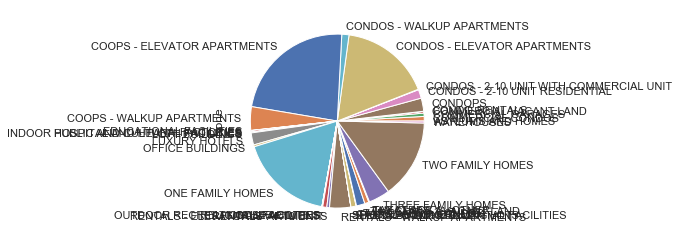

In [43]:
x.groupby('building_class').size().plot(kind='pie')

In [50]:
# enrich

for m in building_class_mapping:
    x.loc[x.building_class.str.contains(m), 'building_class_map'] = m


# this keeps getting decreased, above lines increased
x.loc[x.building_class_map.isna(), 'building_class_map'] = 'OTHER'

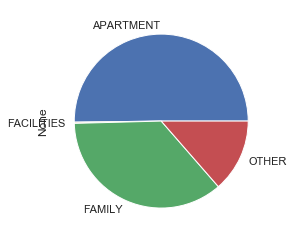

In [51]:

x.groupby('building_class_map').size().plot(kind='pie')

# len(data_enriched[data_enriched.building_class_map.notna()])
# 20K records contains family, 15K+ apartment

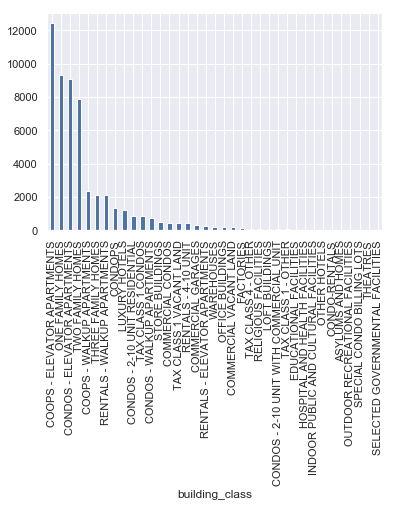

In [52]:
x.groupby('building_class').size().sort_values(ascending=False).plot(kind='bar')

In [56]:
len(data), len(x)

(53702, 53702)

In [54]:
data = x

In [55]:
len(data)

53702

### tax_class_at_present, tax_class_at_sale

In [57]:
x = data.copy()

In [58]:
x.groupby('tax_class_at_present').size()

tax_class_at_present
        195
1     19387
1A      754
1B      408
1C       82
2     26051
2A     1374
2B      478
2C     1519
4      3454
dtype: int64

In [59]:
x[x.tax_class_at_present == '1A'].head(3)

# means no extra white spaces

,neighborhood,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date,borough_name,building_class,building_class_map
212,BATH BEACH,1A,6376,1005,,R3,24 BAY 26TH STREET,202,11214,1,0,1,0,0,0,1,R3,448000.0,2013-03-13,Brooklyn,TAX CLASS 1 CONDOS,OTHER
213,BATH BEACH,1A,6400,1006,,R3,8729 17TH AVENUE,3B,11214,1,0,1,0,0,0,1,R3,400000.0,2012-09-10,Brooklyn,TAX CLASS 1 CONDOS,OTHER
214,BATH BEACH,1A,6400,1107,,R3,8726 BAY 16TH STREET,3A,11214,1,0,1,0,0,2007,1,R3,485000.0,2012-12-31,Brooklyn,TAX CLASS 1 CONDOS,OTHER


In [60]:
x = x[(x.tax_class_at_present != '  ')] #195 rows

In [61]:
len(data), len(x)

(53702, 53507)

In [62]:
x.groupby('tax_class_at_sale').size()

# tax_class_sale is mapped version of tax_class_present

tax_class_at_sale
                 1
  1          20618
  2          29424
  4           3464
dtype: int64

In [63]:
x.tax_class_at_sale.str.len().describe()

# seem 9 whitespaces :)

count    53507.000000
mean         4.000093
std          0.021615
min          4.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          9.000000
Name: tax_class_at_sale, dtype: float64

In [64]:
x = x[x.tax_class_at_sale.str.len() != 9]        #195 rows

In [65]:
len(data), len(x)

(53702, 53506)

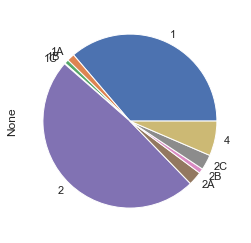

In [66]:
x.groupby('tax_class_at_present').size().plot(kind='pie')

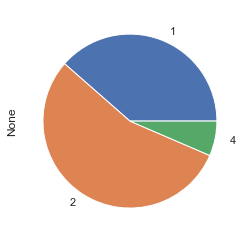

In [67]:
x.groupby('tax_class_at_sale').size().plot(kind='pie')

In [68]:
data = x

### block, lot, easement

In [69]:
x = data.copy()

In [70]:
x.groupby('easement').size()

# delete column

easement
     53506
dtype: int64

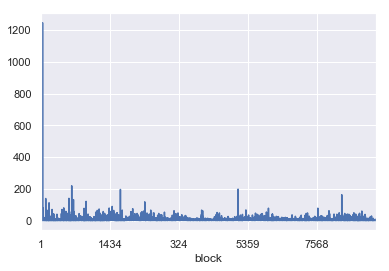

In [71]:
x.groupby('block').size().plot()


# can be deleted

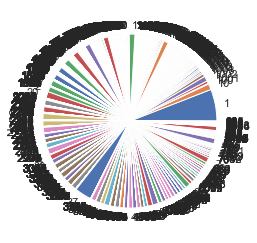

In [72]:
x.groupby('lot').size().plot(kind='pie')

# can be deleted, meaningless

In [73]:
x.drop(['lot', 'block', 'easement'], axis=1, inplace=True)

x.columns

Index(['neighborhood', 'tax_class_at_present', 'building_class_at_present',
       'address', 'apartment_number', 'zipcode', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'gross_square_feet', 'year_built', 'tax_class_at_sale',
       'building_class_at_sale', 'sale_price', 'sale_date', 'borough_name',
       'building_class', 'building_class_map'],
      dtype='object')

In [74]:
data = x

### building_class_at_present, building_class_at_sale

In [84]:
x = data.copy()

In [85]:
x.building_class_at_present.describe(), x.building_class_at_sale.describe()

(count     53506
 unique      137
 top          D4
 freq      12174
 Name: building_class_at_present, dtype: object, count     53506
 unique      131
 top         D4 
 freq      12174
 Name: building_class_at_sale, dtype: object)

In [86]:
# check values length (white spaces ?)

x.building_class_at_sale.str.len().describe()

count    53506.0
mean         4.0
std          0.0
min          4.0
25%          4.0
50%          4.0
75%          4.0
max          4.0
Name: building_class_at_sale, dtype: float64

In [87]:
# no null or empty rows

x[x.building_class_at_sale.isna()].head(2)

,neighborhood,tax_class_at_present,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date,borough_name,building_class,building_class_map


In [88]:
# that's really fantastic :), not 'R3  ' or '  R3'

x[x.building_class_at_sale == ' R3 '].head(2)

,neighborhood,tax_class_at_present,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date,borough_name,building_class,building_class_map
212,BATH BEACH,1A,R3,24 BAY 26TH STREET,202,11214,1,0,1,0,0,0,1,R3,448000.0,2013-03-13,Brooklyn,TAX CLASS 1 CONDOS,OTHER
213,BATH BEACH,1A,R3,8729 17TH AVENUE,3B,11214,1,0,1,0,0,0,1,R3,400000.0,2012-09-10,Brooklyn,TAX CLASS 1 CONDOS,OTHER


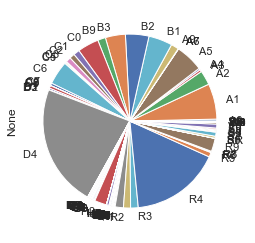

In [89]:
x.groupby('building_class_at_sale').size().plot(kind='pie')

In [91]:
# if we take first char, we can reduce from 130 to ~10 category. much better

x['building_class_at_sale'] = x['building_class_at_sale'].str[1:2]

x['building_class_at_sale'].head()

25    A
26    A
27    A
28    A
30    S
Name: building_class_at_sale, dtype: object

In [92]:
x.drop(['building_class_at_present'], axis=1, inplace=True)

In [93]:
x.columns

Index(['neighborhood', 'tax_class_at_present', 'address', 'apartment_number',
       'zipcode', 'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_sale', 'building_class_at_sale', 'sale_price',
       'sale_date', 'borough_name', 'building_class', 'building_class_map',
       'building_class_at_sale_'],
      dtype='object')

(23, <matplotlib.axes._subplots.AxesSubplot at 0x1a2710f2e8>)

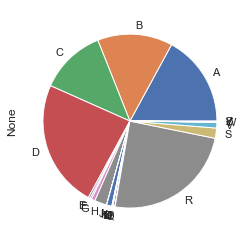

In [95]:
# great potential for dummie :)
k = x.groupby('building_class_at_sale').size()

len(k), k.plot(kind='pie')

In [96]:
data = x

### address, apartment_number, zipcode

In [97]:
x = data.copy()

In [104]:
    
#  white-spaces at the beginning, white-spaces at the end cleared
#  b/w words, white-space remains 
x['address'] = x['address'].str.split(r'(^\s+)|(\s+)$', expand=True)[3]

In [105]:
x.groupby('apartment_number').size().sort_values(ascending=False).head(3)


# 40K+ empty, and nothing special
# remove column

apartment_number
                41569
3A                198
3B                189
dtype: int64

In [106]:
x.drop(['apartment_number'], axis=1, inplace=True)

In [107]:
x.columns

Index(['neighborhood', 'tax_class_at_present', 'address', 'zipcode',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_sale', 'building_class_at_sale', 'sale_price',
       'sale_date', 'borough_name', 'building_class', 'building_class_map',
       'building_class_at_sale_'],
      dtype='object')

In [108]:
data = x

### residential_units, commercial_units, total_units

In [154]:
x = data.copy()

In [155]:
x[['residential_units', 'commercial_units', 'total_units']].head(10)

# total = residental + commercial ?
# if there are dif, can we set to commercial or we should delete  or we may use to create a dummy category ?
# if total = 0 , what we should do?

,residential_units,commercial_units,total_units
25,1,0,1
26,1,0,1
27,1,0,1
28,1,0,1
30,1,1,2
31,1,0,1
32,1,1,2
33,1,0,1
34,1,0,1
36,1,0,1


In [156]:
len(x), x.groupby('total_units').size().sort_values(ascending=False).head(4).sum()

# top 0,1,2,3 covers 94% of records!

(53506, 50415)

#### some checks b/w x and raw_data

In [157]:
len(x[x.total_units.isna()]), len(x[x.commercial_units.isna()]), len(x[x.residential_units.isna()])

(0, 0, 0)

In [158]:
len(raw_data[raw_data.total_units.isna()]), len(raw_data[raw_data.commercial_units.isna()]), \
len(raw_data[raw_data.residential_units.isna()])


(0, 0, 0)

In [159]:
len(x[x.total_units.str.contains(',')]), len(raw_data[raw_data.total_units.str.contains(',')])

# there was ',' in raw_data. so we can change types object to int!

(0, 4)

In [160]:
x.dtypes

neighborhood                       object
tax_class_at_present               object
address                            object
zipcode                            object
residential_units                  object
commercial_units                   object
total_units                        object
land_square_feet                   object
gross_square_feet                  object
year_built                         object
tax_class_at_sale                  object
building_class_at_sale             object
sale_price                        float64
sale_date                  datetime64[ns]
borough_name                       object
building_class                     object
building_class_map                 object
building_class_at_sale_            object
dtype: object

In [161]:
x = x.astype({'total_units': 'int64', 'commercial_units': 'int64', 'residential_units': 'int64'}, copy=False)

In [162]:
x.dtypes

# now they all int

neighborhood                       object
tax_class_at_present               object
address                            object
zipcode                            object
residential_units                   int64
commercial_units                    int64
total_units                         int64
land_square_feet                   object
gross_square_feet                  object
year_built                         object
tax_class_at_sale                  object
building_class_at_sale             object
sale_price                        float64
sale_date                  datetime64[ns]
borough_name                       object
building_class                     object
building_class_map                 object
building_class_at_sale_            object
dtype: object

##### visual understandings

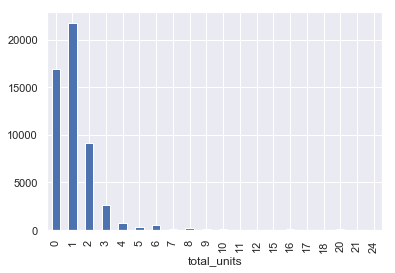

In [167]:
x.groupby('total_units').size().sort_values(ascending=False).head(20).sort_index().plot(kind='bar')

# we can treat as outliers after 10
# it is numeric but 0 has a meaning !

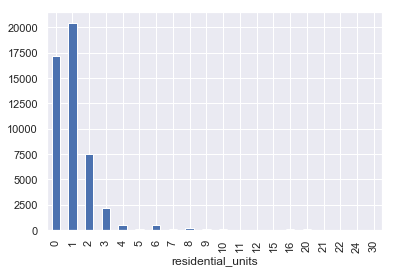

In [182]:
x[x.commercial_units == 0].groupby('residential_units').size() \
                          .sort_values(ascending=False).head(20) \
                          .sort_index().plot(kind='bar')

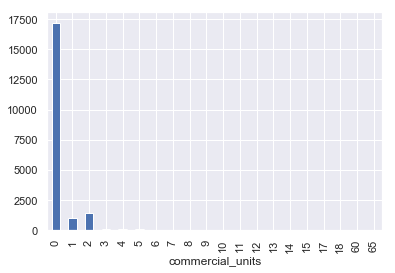

In [181]:
x[x.residential_units == 0].groupby('commercial_units').size()\
                           .sort_values(ascending=False).head(20) \
                           .sort_index().plot(kind='bar')

In [176]:
x[x.building_class == 'FACTORIES'].groupby('commercial_units').size()



commercial_units
0      3
1    121
2     14
3      5
4      4
5      1
dtype: int64

In [177]:
x[x.building_class == 'FACTORIES'].groupby('residential_units').size()

# factory is a commercial type so residential_units mostly 0. Factories also have residential units..

residential_units
0    142
1      4
2      1
4      1
dtype: int64

#### so,

- [ ] is total_units, number or categorical ?
- [ ] in every case, 17K has 0 unit. 
- [ ] we should **tag** as residential and commercial (new feature of category)
- [x] we should use total_units as numerical features

### land_square_feet, gross_square_feet

In [ ]:
x = data.copy()

In [183]:
len(x[x.land_square_feet.str.contains(',')])

# ',' is bad for a potential numeric column

25291

In [ ]:
# replace

for col in ('land_square_feet', 'gross_square_feet'):
    x[col] = x[col].str.replace(r',', '').astype(int)

In [ ]:
z.gross_square_feet.plot.hist(bins=100)

In [ ]:
data_cleaned = data_cleaned[(data_cleaned.gross_square_feet > 0) & (data_cleaned.gross_square_feet <= 20000)]

### end of cleansing

In [ ]:
data_prepared = data.copy()

In [ ]:
data_prepared.columns

In [ ]:
# change column names' order
data_prepared = data[['borough', 'borough_name' , 'neighborhood',
                     'building_class_category', 'building_class', 'building_class_name',
                     'tax_class_at_present', 'tax_class_at_sale', 
                     'block', 'lot', 'easement','building_class_at_present', 'building_class_at_sale', 
                     'address', 'address_', 'apartment_number','zipcode',
                     'residential_units', 'commercial_units', 'total_units',
                     'land_square_feet', 'gross_square_feet', 
                     'year_built','sale_date', 'sale_price']]

data_prepared.head(2)

In [196]:
data_prepared.dtypes

borough_name                         object
neighborhood                         object
building_class_name                  object
tax_class_at_present                 object
building_class_at_present            object
address_                             object
zipcode                               int64
residential_units                    object
commercial_units                     object
total_units                          object
land_square_feet                      int64
gross_square_feet                     int64
year_built                            int64
sale_date                    datetime64[ns]
sale_price                          float64
dtype: object

In [188]:
len(data_prepared)

55568

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a504cd240>,
      dtype=object)

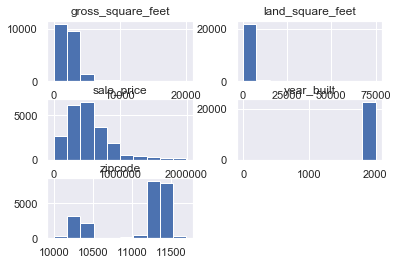

In [251]:
data_prepared.hist()

## Visualize

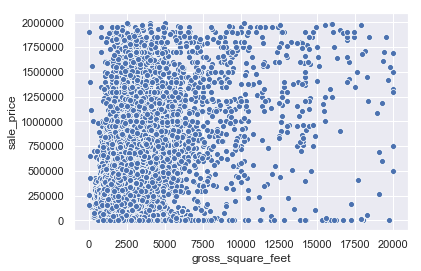

In [261]:
ax1 = sns.scatterplot(x='gross_square_feet', y='sale_price', palette='Set2', data=data_cleaned)


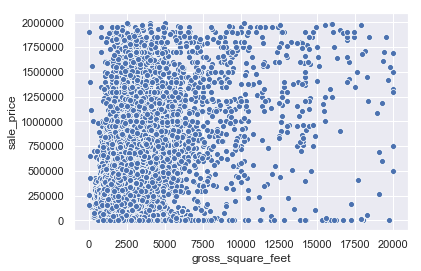

In [263]:
ax10 = sns.scatterplot(x='gross_square_feet', y='sale_price', palette='Set2', data=data_cleaned)


## Export

In [206]:
export_csv = data_prepared.to_csv(r'./dataset/housing/output_after_eda.csv', \
                                  index = None, \
                                  header = True) 

export_csv